In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46127 instead
  warnings.warn(


<Client: 'inproc://137.129.155.67/15791/1' processes=1 threads=4, memory=78.61 GiB>

In [2]:
path = "/home/durand/Documents/OLR/"

indir_data = path + 'Anomaly/'
outdir_TF = path + 'TF2D/'

indir_data_RAW = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'

var_file = 'anom_OLR_brut_ERA5_3H'


In [3]:
year = 2009
latitude = 10.5
longitude = 0.5
day1 = '2009-08-20'
day2 = '2009-09-10'

# ds_RAW = xr.open_mfdataset(indir_data_RAW+'*'+var_file+'*'+str(year)+'.nc', chunks = {'time' : 1}, parallel=True)
# ds_RAW = ds_RAW.assign_coords(lon=(((ds_RAW.lon + 180) % 360) - 180))

ds_FILTER = xr.open_mfdataset(indir_data_FILTERED + '*' + str(year) + '_V2.nc', chunks = {'time' : 1}, parallel=True)
ds_FILTER_2 = xr.open_mfdataset(indir_data_FILTERED + 'ER_SECOND_2.nc', chunks = {'time' : 1}, parallel=True)

ds_ERWAN = xr.open_mfdataset('/cnrm/tropics/user/peyrille/Stage_PFE_Erwan/data/OLR/'+'*'+str(year)+'.nc', chunks = {'time' : 1}, parallel=True)


In [4]:
da_RAW = ds_ERWAN['olr_anom']

In [5]:
da_OLR_Kelvin = ds_FILTER['OLR_Kelvin']
da_OLR_Rossby = ds_FILTER['OLR_Rossby']
da_OLR_MJO = ds_FILTER['OLR_MJO']
da_OLR_MRG = ds_FILTER['OLR_MRG']
da_OLR_EIG = ds_FILTER['OLR_EIG']
da_OLR_WIG = ds_FILTER['OLR_WIG']
da_OLR_TD = ds_FILTER['OLR_TD']
da_OLR_LF = ds_FILTER['OLR_LF'] 

In [6]:
da_FILTER_TOT = da_OLR_Kelvin + \
                da_OLR_Rossby + \
                da_OLR_MJO + \
                da_OLR_MRG + \
                da_OLR_EIG + \
                da_OLR_WIG + \
                da_OLR_TD + \
                da_OLR_LF

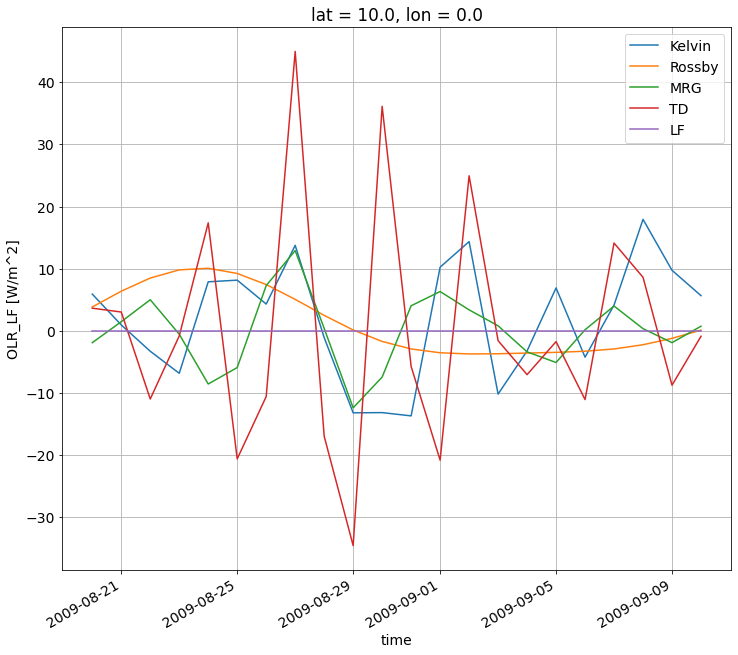

In [7]:
da_OLR_Kelvin.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'Kelvin')
da_OLR_Rossby.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'Rossby')
# da_OLR_MJO.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'MJO')
da_OLR_MRG.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'MRG')
# da_OLR_EIG.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'EIG')
# da_OLR_WIG.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'WIG')
da_OLR_TD.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'TD')
da_OLR_LF.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'LF')

plt.legend()
plt.grid()

In [8]:
levels = np.arange(-100,100.1,10)
levels

array([-100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,
        -10.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,
         80.,   90.,  100.])

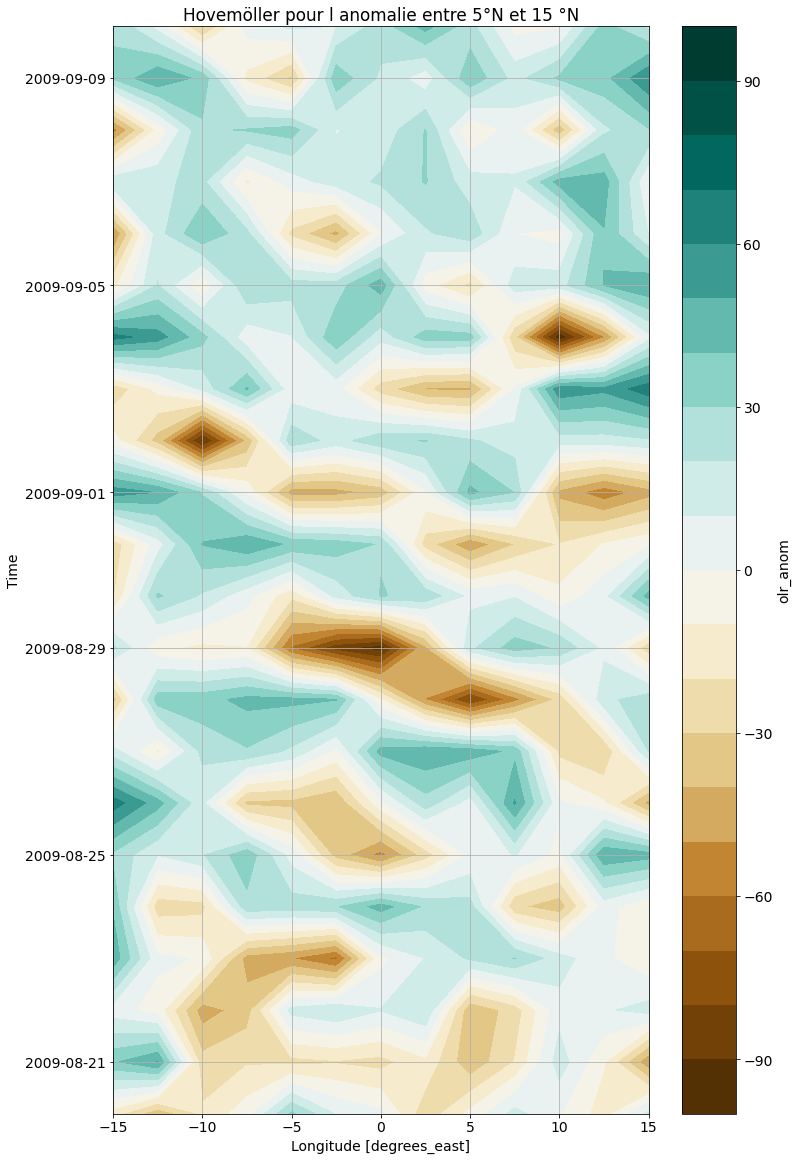

In [9]:
_hov = da_RAW.sel(lat = slice(9,11)).sum('lat').sel(lon = slice(-15,15))
_hov = _hov.sel(time = slice('2009-08-20','2009-09-10'))

plt.rc("figure", figsize=(12,10*2))
_hov.plot.contourf(levels = levels, cmap = 'BrBG')
plt.title('Hovemöller pour l anomalie entre 5°N et 15 °N')
plt.grid()

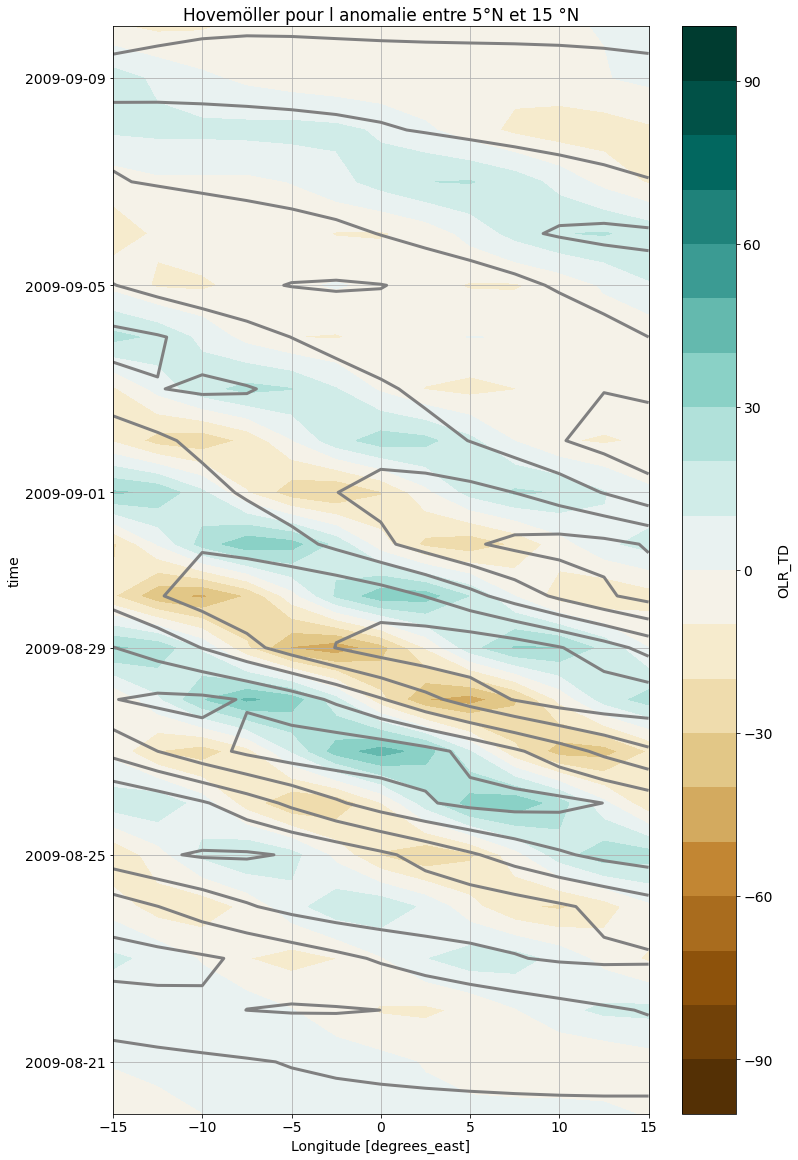

In [21]:
plt.rcParams["lines.linewidth"] = 3

_hov = da_OLR_TD.sel(lat = slice(9,11)).sum('lat').sel(lon = slice(-15,15))
_hov = _hov.sel(time = slice('2009-08-20','2009-09-10'))


_hov_MR = da_OLR_MRG.sel(lat = slice(9,11)).sum('lat').sel(lon = slice(-15,15))
_hov_MR = _hov_MR.sel(time = slice('2009-08-20','2009-09-10'))

plt.rc("figure", figsize=(12,10*2))
_hov.plot.contourf(levels = levels, cmap = 'BrBG')
_hov_MR.plot.contour(levels = levels/2, cmap = 'grey')
plt.title('Hovemöller pour l anomalie entre 5°N et 15 °N')
plt.grid()
plt.show()

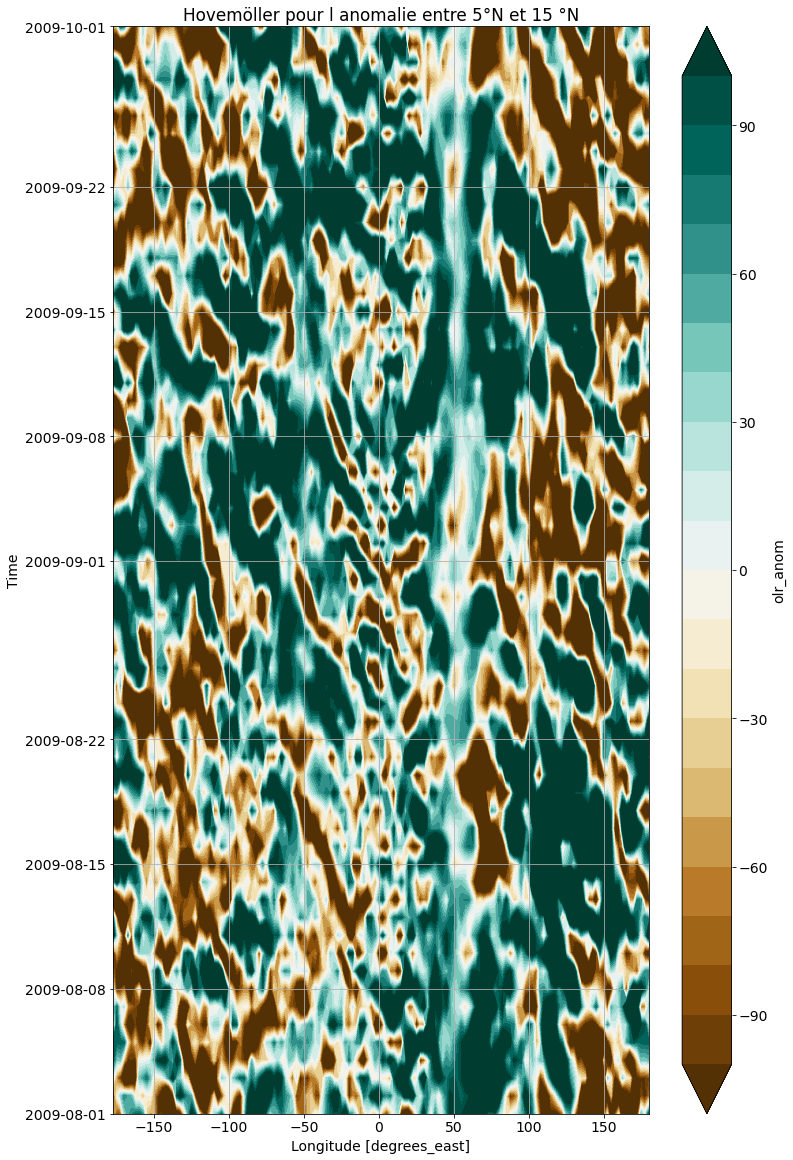

In [11]:
_hov = da_RAW.sel(lat = slice(5,15)).sum('lat')
_hov = _hov.sel(time = slice('2009-08-01','2009-10-01'))

plt.rc("figure", figsize=(12,10*2))
_hov.plot.contourf(levels = levels, cmap = 'BrBG')
plt.title('Hovemöller pour l anomalie entre 5°N et 15 °N')
plt.grid()

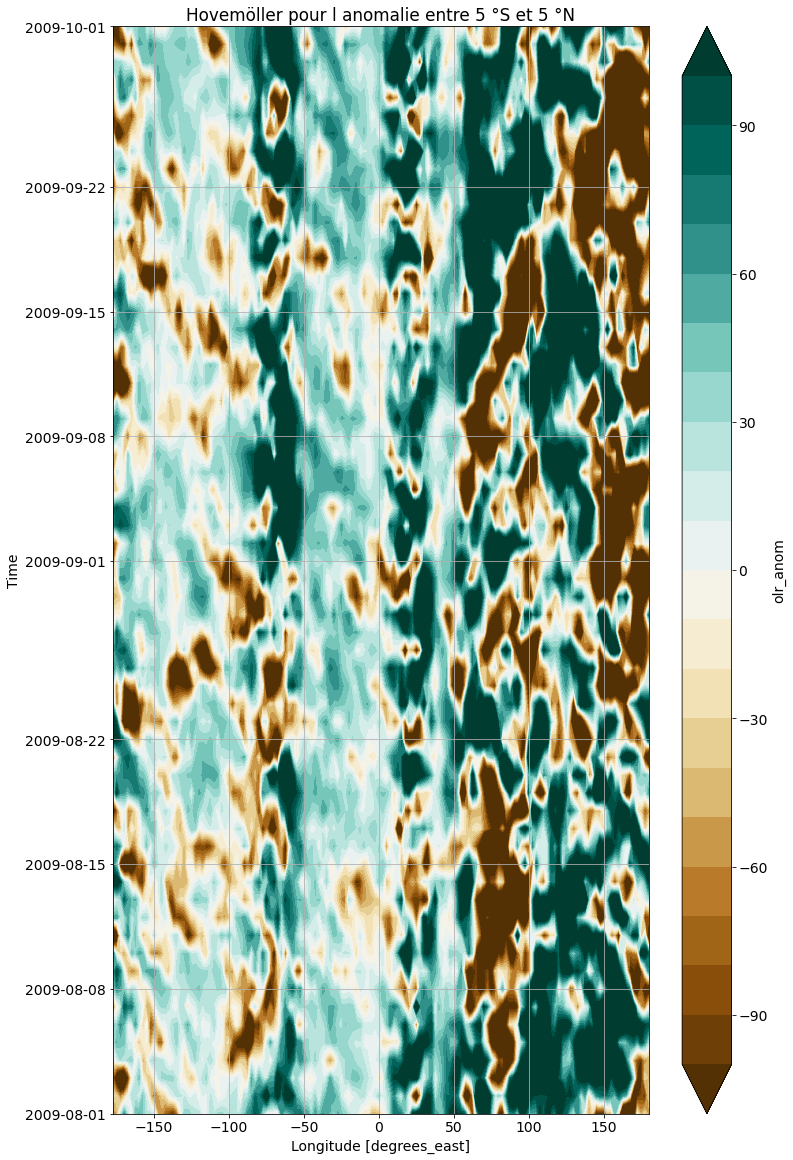

In [12]:
_hov = da_RAW.sel(lat = slice(-5,5)).sum('lat')
_hov = _hov.sel(time = slice('2009-08-01','2009-10-01'))

plt.rc("figure", figsize=(12,10*2))
_hov.plot.contourf(levels = levels, cmap = 'BrBG')
plt.title('Hovemöller pour l anomalie entre 5 °S et 5 °N')
plt.grid()

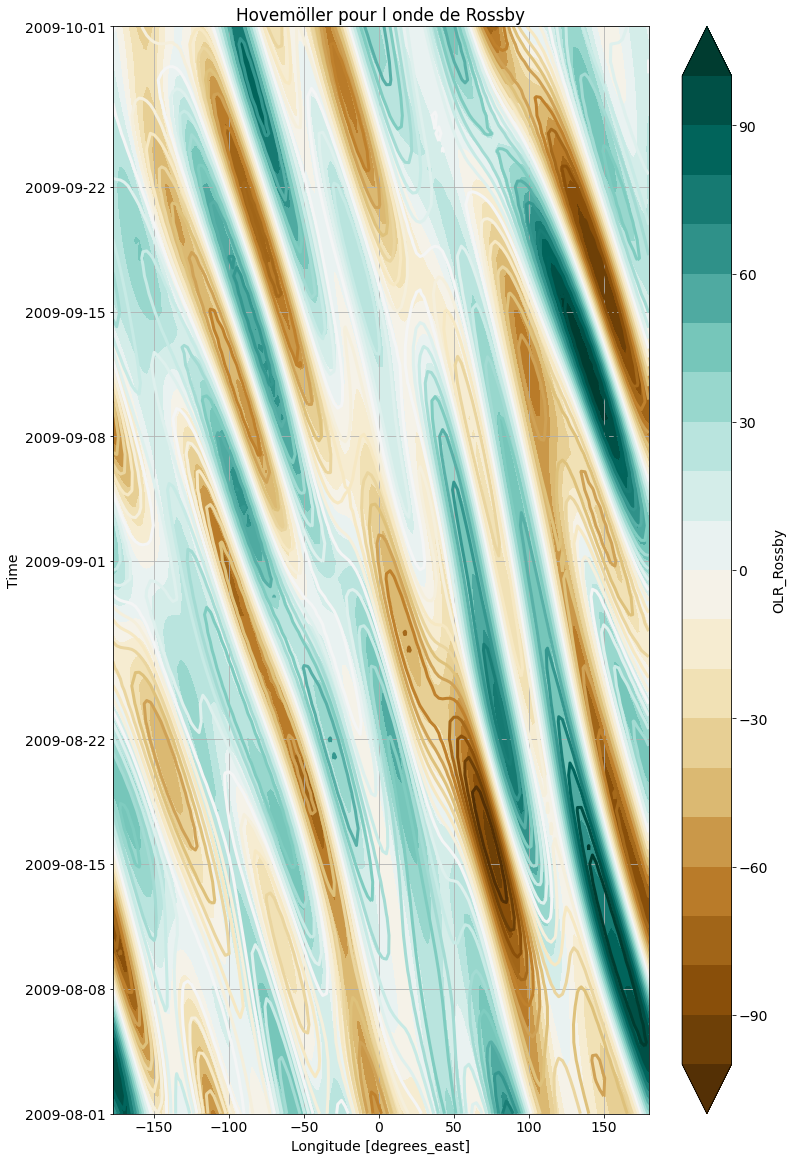

In [13]:
_hov = da_OLR_Rossby.sel(lat = slice(5,15)).sum('lat')
# _hov = ds_FILTER.sel(lat = slice(-15,15)).sel(lon = longitude, method = 'nearest').sel(time = slice(day1, day2))
_hov = _hov.sel(time = slice('2009-08-01','2009-10-01'))
_hov_E = ds_ERWAN['er_wk'].sel(lat = slice(5,15)).sum('lat')
_hov_E = _hov_E.sel(time = slice('2009-08-01','2009-10-01'))


plt.rc("figure", figsize=(12,10*2))
_hov.plot.contourf(levels = levels, cmap = 'BrBG')
_hov_E.plot.contour(levels = levels, cmap = 'BrBG')
plt.title('Hovemöller pour l onde de Rossby')
plt.grid()

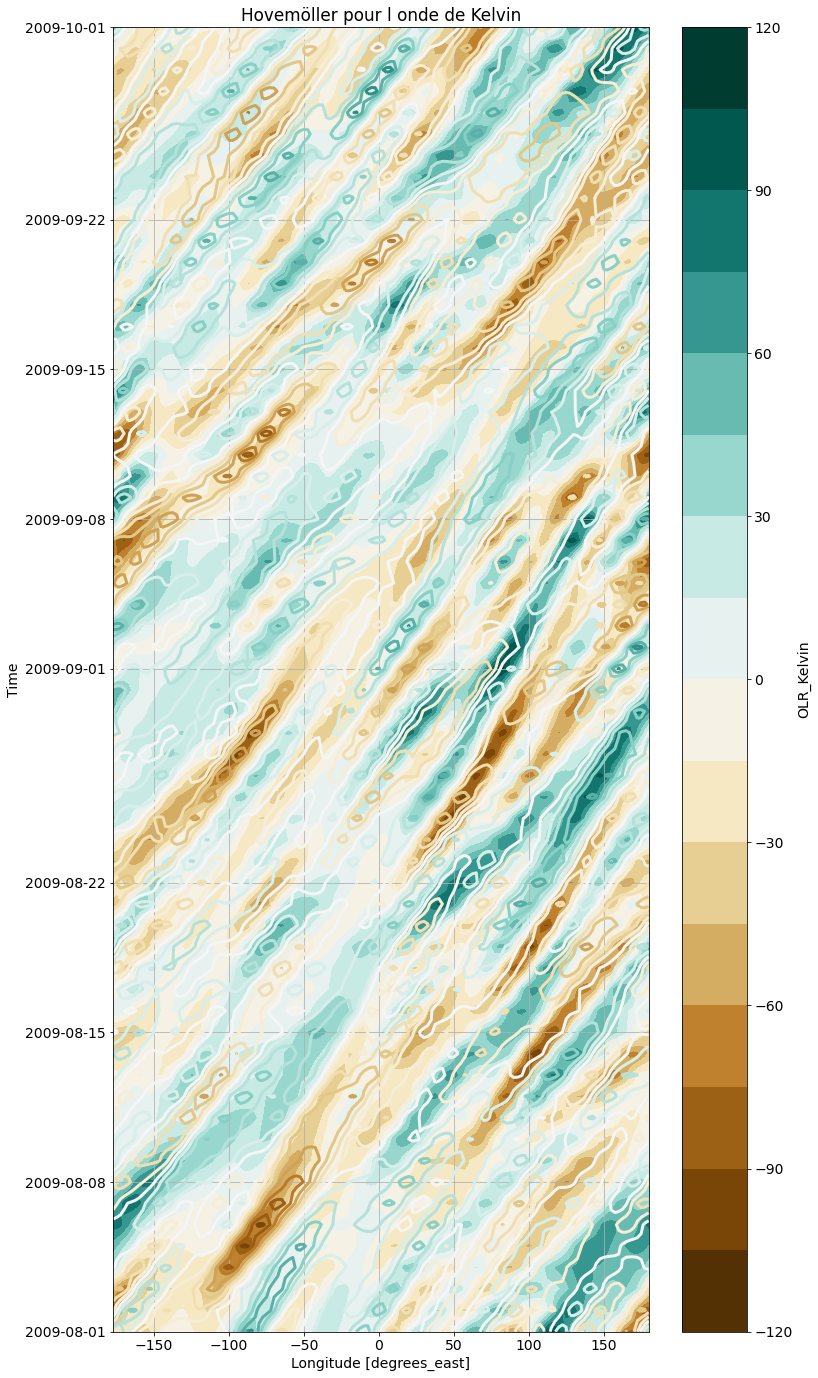

In [14]:
_hov = da_OLR_Kelvin.sel(lat = slice(-5,5)).sum('lat')
# _hov = ds_FILTER.sel(lat = slice(-15,15)).sel(lon = longitude, method = 'nearest').sel(time = slice(day1, day2))
_hov = _hov.sel(time = slice('2009-08-01','2009-10-01'))
_hov_E = ds_ERWAN['klv_wk'].sel(lat = slice(5,15)).sum('lat')
_hov_E = _hov_E.sel(time = slice('2009-08-01','2009-10-01'))


plt.rc("figure", figsize=(12,12*2))
_hov.plot.contourf(levels = 20, cmap = 'BrBG')
_hov_E.plot.contour(levels = 20, cmap = 'BrBG')
plt.title('Hovemöller pour l onde de Kelvin')
plt.grid()

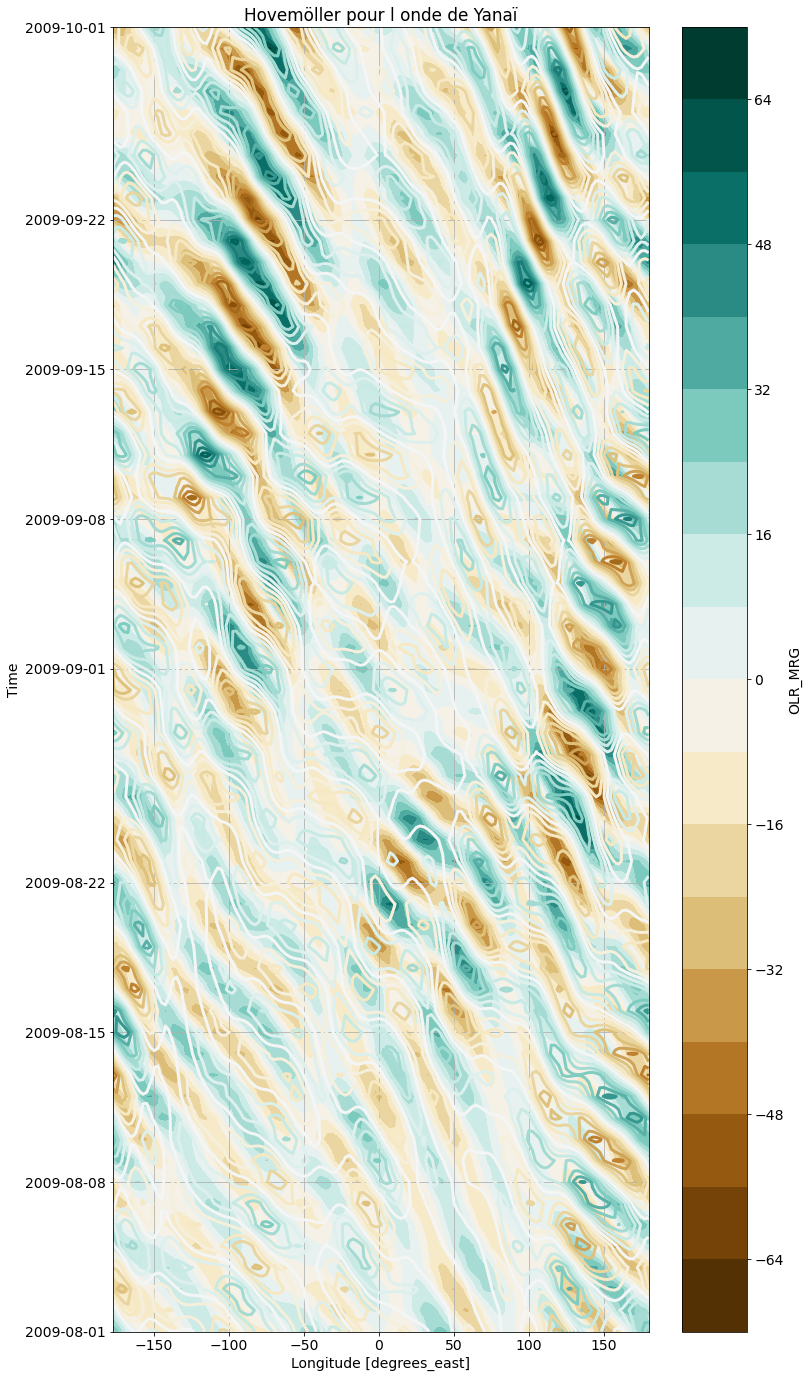

In [15]:
_hov = da_OLR_MRG.sel(lat = slice(-5,5)).sum('lat')
# _hov = ds_FILTER.sel(lat = slice(-15,15)).sel(lon = longitude, method = 'nearest').sel(time = slice(day1, day2))
_hov = _hov.sel(time = slice('2009-08-01','2009-10-01'))
_hov_E = ds_ERWAN['mrg'].sel(lat = slice(5,15)).sum('lat')
_hov_E = _hov_E.sel(time = slice('2009-08-01','2009-10-01'))


plt.rc("figure", figsize=(12,12*2))
_hov.plot.contourf(levels = 20, cmap = 'BrBG')
_hov_E.plot.contour(levels = 20, cmap = 'BrBG')
plt.title('Hovemöller pour l onde de Yanaï')
plt.grid()

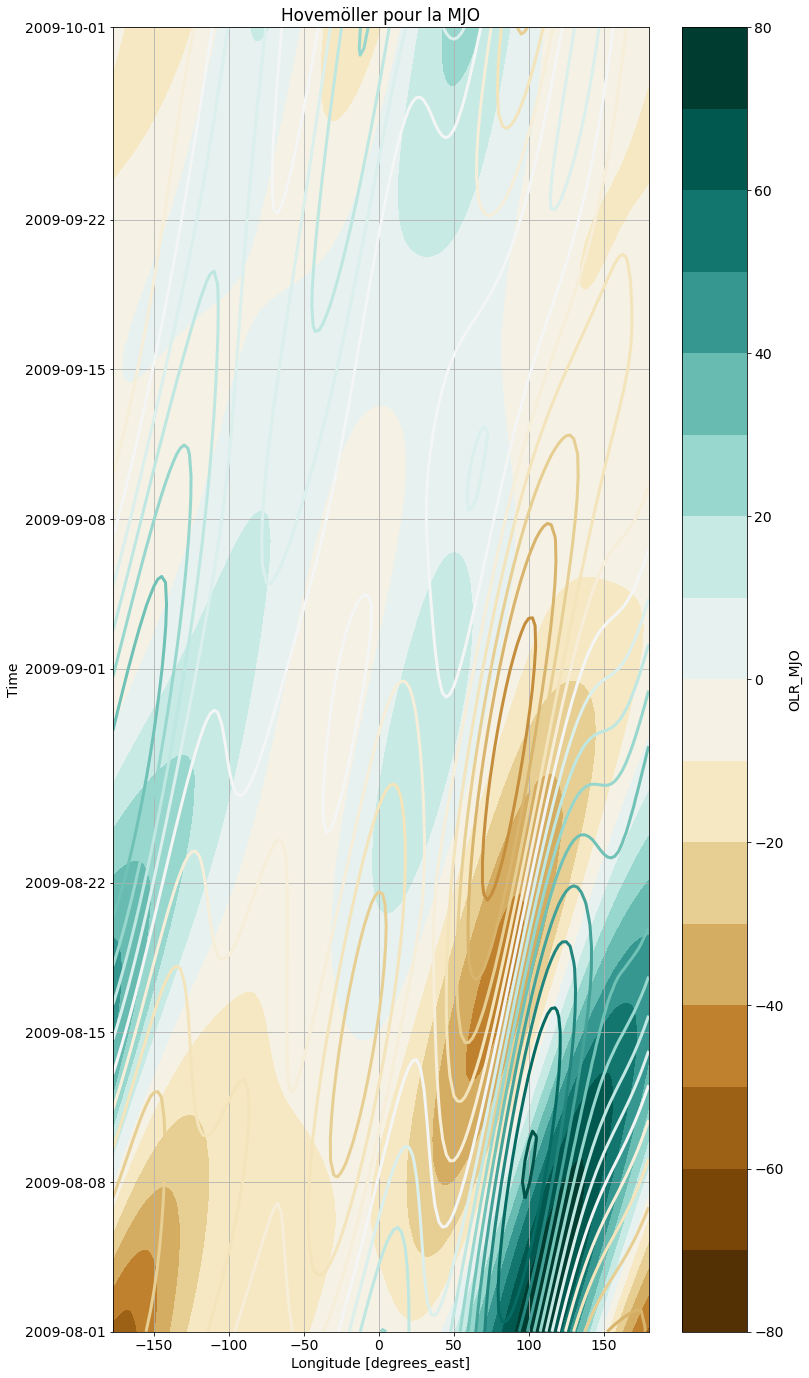

In [16]:
_hov = da_OLR_MJO.sel(lat = slice(-5,5)).sum('lat')
# _hov = ds_FILTER.sel(lat = slice(-15,15)).sel(lon = longitude, method = 'nearest').sel(time = slice(day1, day2))
_hov = _hov.sel(time = slice('2009-08-01','2009-10-01'))
_hov_E = ds_ERWAN['mjo_wk'].sel(lat = slice(5,15)).sum('lat')
_hov_E = _hov_E.sel(time = slice('2009-08-01','2009-10-01'))


plt.rc("figure", figsize=(12,12*2))
_hov.plot.contourf(levels = 20, cmap = 'BrBG')
_hov_E.plot.contour(levels = 20, cmap = 'BrBG')
plt.title('Hovemöller pour la MJO')
plt.grid()